<a href="https://colab.research.google.com/github/Iflgit/GB_NLP/blob/main/l3/HW-3-colab_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip show nltk gensim bokeh pandas

In [2]:
# !pip uninstall numpy
# !pip install numpy
# !pip show pandas

In [3]:
# !pip install -q --upgrade nltk gensim bokeh pandas

import nltk
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [4]:
import pandas as pd
import numpy as np
from nltk.tokenize import word_tokenize
from gensim.models import Word2Vec
from sklearn.manifold import TSNE

In [5]:
import re
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.corpus import stopwords
from string import punctuation

## Запилим пословный машинный перевод!

In [6]:
!wget -O ukr_rus.train.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1vAK0SWXUqei4zTimMvIhH3ufGPsbnC_O"
!wget -O ukr_rus.test.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1W9R2F8OeKHXruo2sicZ6FgBJUTJc8Us_"
!wget -O fairy_tale.txt -qq --no-check-certificate "https://drive.google.com/uc?export=download&id=1sq8zSroFeg_afw-60OmY8RATdu_T1tej"

# Install the PyDrive wrapper & import libraries.
# This only needs to be done once per notebook.
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
# This only needs to be done once per notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id': '1d7OXuil646jUeDS1JNhP9XWlZogv6rbu'})
downloaded.GetContentFile('cc.ru.300.vec.zip')

downloaded = drive.CreateFile({'id': '1yAqwqgUHtMSfGS99WLGe5unSCyIXfIxi'})
downloaded.GetContentFile('cc.uk.300.vec.zip')

!unzip cc.ru.300.vec.zip
!unzip cc.uk.300.vec.zip

Archive:  cc.ru.300.vec.zip
  inflating: cc.ru.300.vec           
Archive:  cc.uk.300.vec.zip
  inflating: cc.uk.300.vec           


Напишем простенькую реализацию модели машинного перевода.

Идея основана на статье [Word Translation Without Parallel Data](https://arxiv.org/pdf/1710.04087.pdf). У авторов в репозитории еще много интересного: [https://github.com/facebookresearch/MUSE](https://github.com/facebookresearch/MUSE).

А мы будем переводить с украинского на русский.

![](https://raw.githubusercontent.com/yandexdataschool/nlp_course/master/resources/blue_cat_blue_whale.png)   
*синій кіт* vs. *синій кит*

In [7]:
from gensim.models import KeyedVectors

ru_emb = KeyedVectors.load_word2vec_format("cc.ru.300.vec")
uk_emb = KeyedVectors.load_word2vec_format("cc.uk.300.vec")

Посмотрим на пару серпень-август (являющихся переводом)

In [8]:
ru_emb.most_similar([ru_emb["август"]])

[('август', 1.0),
 ('июль', 0.9383153915405273),
 ('сентябрь', 0.9240028858184814),
 ('июнь', 0.9222575426101685),
 ('октябрь', 0.9095538854598999),
 ('ноябрь', 0.8930036425590515),
 ('апрель', 0.8729087114334106),
 ('декабрь', 0.8652557730674744),
 ('март', 0.8545796275138855),
 ('февраль', 0.8401416540145874)]

In [9]:
uk_emb.most_similar([uk_emb["серпень"]])

[('серпень', 0.9999999403953552),
 ('липень', 0.9096440076828003),
 ('вересень', 0.901697039604187),
 ('червень', 0.8992519378662109),
 ('жовтень', 0.8810408711433411),
 ('листопад', 0.8787633776664734),
 ('квітень', 0.8592804670333862),
 ('грудень', 0.8586863279342651),
 ('травень', 0.8408110737800598),
 ('лютий', 0.8256431818008423)]

In [10]:
ru_emb.most_similar([uk_emb["серпень"]])

[('Недопустимость', 0.24435284733772278),
 ('конструктивность', 0.23293080925941467),
 ('офор', 0.23256804049015045),
 ('deteydlya', 0.23031717538833618),
 ('пресечении', 0.22632381319999695),
 ('одностороннего', 0.22608885169029236),
 ('подход', 0.2230587601661682),
 ('иболее', 0.22003726661205292),
 ('2015Александр', 0.21872764825820923),
 ('конструктивен', 0.21796566247940063)]

In [11]:
def load_word_pairs(filename):
    uk_ru_pairs = []
    uk_vectors = []
    ru_vectors = []
    with open(filename, "r", encoding='utf8') as inpf:
        for line in inpf:
            uk, ru = line.rstrip().split("\t")
            if uk not in uk_emb or ru not in ru_emb:
                continue
            uk_ru_pairs.append((uk, ru))
            uk_vectors.append(uk_emb[uk])
            ru_vectors.append(ru_emb[ru])
    return uk_ru_pairs, np.array(uk_vectors), np.array(ru_vectors)


uk_ru_train, X_train, Y_train = load_word_pairs("ukr_rus.train.txt")
uk_ru_test, X_test, Y_test = load_word_pairs("ukr_rus.test.txt")

### Учим маппинг из одного пространства эмбеддингов в другое

У нас есть пары слов, соответствующих друг другу, и их эмбеддинги. Найдем преобразование из одного пространства в другое, чтобы приблизить известные нам слова:

$$W^*= \arg\min_W ||WX - Y||_F, \text{где} ||*||_F - \text{норма Фробениуса}$$

Эта функция очень похожа на линейную регрессию (без биаса).

**Задание** Реализуйте её - воспользуйтесь `LinearRegression` из sklearn с `fit_intercept=False`:

In [12]:
from sklearn.linear_model import LinearRegression

In [13]:
?LinearRegression

In [14]:
mapping = LinearRegression(fit_intercept=False).fit(X_train, Y_train)

In [28]:
mapping.score(X_train, Y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/base.py:434: FutureWarning: The default value of multioutput (not exposed in score method) will change from 'variance_weighted' to 'uniform_average' in 0.23 to keep consistent with 'metrics.r2_score'. To specify the default value manually and avoid the warning, please either call 'metrics.r2_score' directly or make a custom scorer with 'metrics.make_scorer' (the built-in scorer 'r2' uses multioutput='uniform_average').
  "multioutput='uniform_average').", FutureWarning)


0.5498096957096711

Проверим, куда перейдет `серпень`:

In [15]:
august = mapping.predict(uk_emb["серпень"].reshape(1, -1))
ru_emb.most_similar(august)

[('апрель', 0.8541285991668701),
 ('июнь', 0.8411202430725098),
 ('март', 0.839699387550354),
 ('сентябрь', 0.835986852645874),
 ('февраль', 0.8329297304153442),
 ('октябрь', 0.8311845660209656),
 ('ноябрь', 0.8278923034667969),
 ('июль', 0.8234529495239258),
 ('август', 0.8120501041412354),
 ('декабрь', 0.803900420665741)]

In [16]:
ru_emb.most_similar(mapping.predict(uk_emb["серпень"].reshape(1, -1)))

[('апрель', 0.8541285991668701),
 ('июнь', 0.8411202430725098),
 ('март', 0.839699387550354),
 ('сентябрь', 0.835986852645874),
 ('февраль', 0.8329297304153442),
 ('октябрь', 0.8311845660209656),
 ('ноябрь', 0.8278923034667969),
 ('июль', 0.8234529495239258),
 ('август', 0.8120501041412354),
 ('декабрь', 0.803900420665741)]

Должно получиться, что в топе содержатся разные месяцы, но август не первый.

Будем мерять percision top-k с k = 1, 5, 10.

**Задание** Реализуйте следующую функцию:

In [17]:
# [item for item in august[:12] if 'август' in item]

In [18]:
# 'август' in dict(ru_emb.most_similar(august)[:10]).keys()

In [46]:
def precision(pairs, mapped_vectors, topn=1):
    """
    :args:
        pairs = list of right word pairs [(uk_word_0, ru_word_0), ...]
        mapped_vectors = list of embeddings after mapping from source embedding space to destination embedding space
        topn = the number of nearest neighbours in destination embedding space to choose from
    :returns:
        precision_val, float number, total number of words for those we can find right translation at top K.
    """
    assert len(pairs) == len(mapped_vectors)
    num_matches = 0
    for i, (_, ru) in enumerate(pairs):
      # print(topn, ru_emb.most_similar(mapped_vectors))
      if ru in dict(ru_emb.most_similar(mapped_vectors[i].reshape(1, -1), topn=topn)):
        # print('bingo')
        num_matches += 1
    precision_val = num_matches / len(pairs)
    return precision_val

In [47]:
assert precision([("серпень", "август")], august, topn=5) == 0.0
assert precision([("серпень", "август")], august, topn=9) == 1.0
assert precision([("серпень", "август")], august, topn=10) == 1.0

In [48]:
ru_emb.most_similar(Y_test)

[('это', 0.6054540276527405),
 ('этот', 0.5874260663986206),
 ('конечно', 0.5778403282165527),
 ('все-таки', 0.5725287199020386),
 ('только', 0.5686001181602478),
 ('наверное', 0.5645052790641785),
 ('вообще', 0.5618256330490112),
 ('опять', 0.558722198009491),
 ('даже', 0.5572904348373413),
 ('ведь', 0.5555438995361328)]

In [49]:
uk_ru_test[:15]

[('або', 'либо'),
 ('активний', 'активный'),
 ('актор', 'актер'),
 ('але', 'ж'),
 ('асамблея', 'собрание'),
 ('бабуся', 'бабушка'),
 ('багажник', 'ствол'),
 ('бажати', 'желать'),
 ('башта', 'башня'),
 ('бізнес', 'бизнес'),
 ('бійка', 'драка'),
 ('блискавка', 'молния'),
 ('братися', 'браться'),
 ('будиночок', 'домик'),
 ('будівництво', 'строительство')]

In [50]:
precision(uk_ru_test, Y_test)

1.0

In [51]:
ru_emb.most_similar(Y_test)

[('это', 0.6054540276527405),
 ('этот', 0.5874260663986206),
 ('конечно', 0.5778403282165527),
 ('все-таки', 0.5725287199020386),
 ('только', 0.5686001181602478),
 ('наверное', 0.5645052790641785),
 ('вообще', 0.5618256330490112),
 ('опять', 0.558722198009491),
 ('даже', 0.5572904348373413),
 ('ведь', 0.5555438995361328)]

In [52]:
assert precision(uk_ru_test, X_test) == 0.0
assert precision(uk_ru_test, Y_test) == 1.0

In [53]:
precision_top1 = precision(uk_ru_test, mapping.predict(X_test), 1)
precision_top5 = precision(uk_ru_test, mapping.predict(X_test), 5)

assert precision_top1 >= 0.635
assert precision_top5 >= 0.813

### Улучшаем маппинг

Можно показать, что маппинг лучше строить ортогональным:
$$W^*= \arg\min_W ||WX - Y||_F \text{, где: } W^TW = I$$

Искать его можно через SVD:
$$X^TY=U\Sigma V^T\text{, singular value decompostion}$$

$$W^*=UV^T$$

**Задание** Реализуйте эту функцию.

In [54]:
def learn_transform(X_train, Y_train):
    """ 
    :returns: W* : float matrix[emb_dim x emb_dim] as defined in formulae above
    """
    U, S, VT = np.linalg.svd(np.matmul(X_train.T, Y_train), full_matrices=False)
    return np.matmul(U, VT)
    

In [55]:
W = learn_transform(X_train, Y_train)

In [56]:
ru_emb.most_similar([np.matmul(uk_emb["серпень"], W)])

[('апрель', 0.8237907886505127),
 ('сентябрь', 0.8049713373184204),
 ('март', 0.8025654554367065),
 ('июнь', 0.8021842241287231),
 ('октябрь', 0.8001736402511597),
 ('ноябрь', 0.7934483885765076),
 ('февраль', 0.7914121150970459),
 ('июль', 0.7908109426498413),
 ('август', 0.7891016602516174),
 ('декабрь', 0.7686373591423035)]

In [57]:
assert precision(uk_ru_test, np.matmul(X_test, W)) >= 0.653
assert precision(uk_ru_test, np.matmul(X_test, W), 5) >= 0.824

### Пишем переводчик

Реализуем простой пословный переводчик - для каждого слова будем искать его ближайшего соседа в общем пространстве эмбеддингов. Если слова нет в эмбеддингах - просто копируем его.

In [60]:
with open("fairy_tale.txt", "r") as in_f:
    uk_sentences = [line.rstrip().lower() for line in in_f]

uk_sentences[:5]

['лисичка - сестричка і вовк - панібрат',
 'як була собі лисичка , да й пішла раз до однії баби добувать огню ; ввійшла у хату да й каже : " добрий день тобі , бабусю !',
 'дай мені огня " .',
 'а баба тільки що вийняла із печі пирожок із маком , солодкий , да й положила , щоб він прохолов ; а лисичка се і підгледала , да тілько що баба нахилилась у піч , щоб достать огня , то лисичка зараз ухватила пирожок да і драла з хати , да , біжучи , весь мак із його виїла , а туда сміття наклала .',
 'прибігла на поле , аж там пасуть хлопці бичків .']

In [81]:
def translate(sentence):
    """
    :args:
        sentence - sentence in Ukrainian (str)
    :returns:
        translation - sentence in Russian (str)

    * find ukrainian embedding for each word in sentence
    * transform ukrainian embedding vector
    * find nearest russian word and replace
    """
    result = ''
    for word in nltk.tokenize.word_tokenize(sentence):
      try:
        result += ru_emb.most_similar(np.matmul(uk_emb[word], W).reshape(1, -1), topn=1)[0][0] + ' '
      except:
        result += word + ' '
    return result.strip()

In [87]:
translate(".")
# translate("1 , 3")
# translate("кіт зловив мишу")

'.'

In [88]:
assert translate(".") == "."
assert translate("1 , 3") == "1 , 3"
assert translate("кіт зловив мишу") == "кот поймал мышку"

In [89]:
for sentence in uk_sentences:
    print("src: {}\ndst: {}\n".format(sentence, translate(sentence)))

src: лисичка - сестричка і вовк - панібрат
dst: лисичка – сестричка и волк – панібрат

src: як була собі лисичка , да й пішла раз до однії баби добувать огню ; ввійшла у хату да й каже : " добрий день тобі , бабусю !
dst: как была себе лисичка , че и пошла раз к однії бабы добувать огня ; вошла во избу че и говорит : `` хороший день тебе , бабушку !

src: дай мені огня " .
dst: дай мне огня `` .

src: а баба тільки що вийняла із печі пирожок із маком , солодкий , да й положила , щоб він прохолов ; а лисичка се і підгледала , да тілько що баба нахилилась у піч , щоб достать огня , то лисичка зараз ухватила пирожок да і драла з хати , да , біжучи , весь мак із його виїла , а туда сміття наклала .
dst: а бабка только что вынула со печи пирожок со маком , сладкий , че и согнула , чтобы он прохолов ; а лисичка ой и підгледала , че токмо что бабка качнулась во печь , чтобы достать огня , то лисичка сейчас ухватила пирожок че и деру со хаты , че , пробежать , весь мак со его виїла , а туда му

# Дополнительные материалы
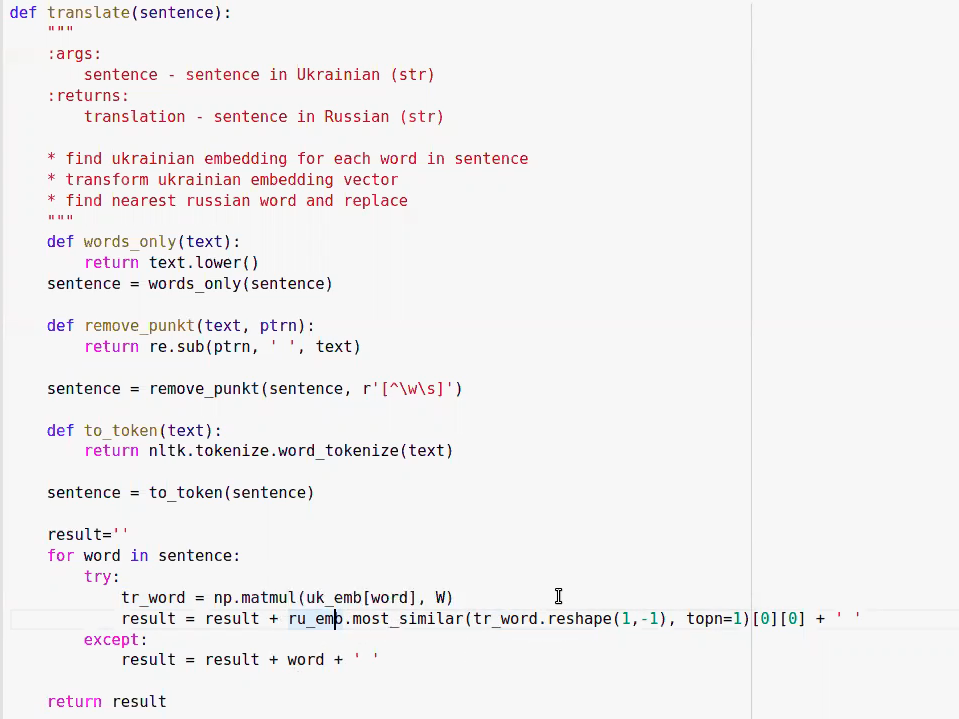

## Почитать
### База:  
[On word embeddings - Part 1, Sebastian Ruder](http://ruder.io/word-embeddings-1/)  
[Deep Learning, NLP, and Representations, Christopher Olah](http://colah.github.io/posts/2014-07-NLP-RNNs-Representations/)  

### Как кластеризовать смыслы многозначных слов:  
[Making Sense of Word Embeddings (2016), Pelevina et al](http://anthology.aclweb.org/W16-1620)    

### Как оценивать эмбеддинги
[Evaluation methods for unsupervised word embeddings (2015), T. Schnabel](http://www.aclweb.org/anthology/D15-1036)  
[Intrinsic Evaluation of Word Vectors Fails to Predict Extrinsic Performance (2016), B. Chiu](https://www.aclweb.org/anthology/W/W16/W16-2501.pdf)  
[Problems With Evaluation of Word Embeddings Using Word Similarity Tasks (2016), M. Faruqui](https://arxiv.org/pdf/1605.02276.pdf)  
[Improving Reliability of Word Similarity Evaluation by Redesigning Annotation Task and Performance Measure (2016), Oded Avraham, Yoav Goldberg](https://arxiv.org/pdf/1611.03641.pdf)  
[Evaluating Word Embeddings Using a Representative Suite of Practical Tasks (2016), N. Nayak](https://cs.stanford.edu/~angeli/papers/2016-acl-veceval.pdf)  


## Посмотреть
[Word Vector Representations: word2vec, Lecture 2, cs224n](https://www.youtube.com/watch?v=ERibwqs9p38)